# Nearest Neighbors on NFTs

Requirements:

* `Embeddings.npy` : Numpy array containing Embeddings for all NFTs - Compute or [Download](https://drive.google.com/file/d/1teQni4MUIFxlmxnJQJGb2PmGf2GmQIZi/view?usp=sharing)
* `imagelist.txt`  : A list of image files (path) correspondence to the embeddings above
* `AuctionData.zip`: A price information about each NFT
* [Download NFT Images](https://drive.google.com/file/d/1uo1mXRRkXcrY1u1bkWj_aEsoW6M3L_7o/view?usp=sharing) and Extract them in a folder named `NFTs`

In [1]:
import torch
import torch.nn as nn

from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np

from torchvision.datasets import ImageFolder

from PIL import Image
from matplotlib import pyplot as plt

from glob import glob

from tqdm import tqdm

import json
import faiss

### Load the Embeddings

In [2]:
embds = np.load('Embeddings.npy')
print(embds.shape)

(23470, 2048, 7, 7)


In [3]:
# Reshape to have one big vector
embds = embds.reshape(-1, 2048*7*7)
print(embds.shape)

(23470, 100352)


## Nearest Search via FAISS

In [4]:
# Cosine Similarity

class FaissCosineClassifier:
  def __init__(self, k=5):
    self.cindex = None
    self.k = k

  def fit(self, X):
    self.cindex = faiss.index_factory(X.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
    X = np.copy(X)
    X = X.astype(np.float32)
    faiss.normalize_L2(X)
    self.cindex.add(X)
  
  def get_distances_and_indices(self, Q):
    Q = np.copy(Q)
    faiss.normalize_L2(Q)
    distances, indices = self.cindex.search(Q.astype(np.float32), k=self.k)
    return np.copy(distances), np.copy(indices)
  
# Standard L2 Distance

class FaissKNeighbors:
  def __init__(self, k=5):
    self.index = None
    self.k = k

  def fit(self, X):
    self.index = faiss.IndexFlatL2(X.shape[1])
    self.index.add(X.astype(np.float32))
  
  def get_distances_and_indices(self, X):
    distances, indices = self.index.search(X.astype(np.float32), k=self.k)
    return np.copy(distances), np.copy(indices)

### Create Nearest Searcher

In [5]:
cosknn = FaissCosineClassifier(k=6)

In [6]:
cosknn.fit(embds)

### Image Files (path)

In [8]:
image_files = None
with open('imagelist.txt', 'r') as f:
  image_files = f.readlines()

image_files = [f.strip() for f in image_files]

### Helpers to read Price Information

In [9]:
def item_generator(json_input, lookup_key):
  if isinstance(json_input, dict):
    for k, v in json_input.items():
      if k == lookup_key:
        yield v
      else:
        yield from item_generator(v, lookup_key)
  elif isinstance(json_input, list):
    for item in json_input:
      yield from item_generator(item, lookup_key)

### Extract `AuctionData.zip` and fix the path below

In [10]:
# For getting NFT price information, Unzip AuctionData.zip file and fix the path below

def get_price_info(art_file):
  nft_id = int(art_file.split('/')[-1].split('NFT-')[-1].split('.')[0])
  # Fix the following path:
  with open(f'./AuctionData/FND-{nft_id}.json') as f:
    nft_json = json.load(f)

  if 'Sold' not in list(item_generator(nft_json['data']['nft']['nftHistory'], 'event')):
    return ['Not Sold']
  else:
    sold_prices = []

    for auction_item in nft_json['data']['nft']['nftHistory']:
      if auction_item['event'] == 'Sold':
        sold_prices.append(float(auction_item['amountInETH']))
    return sold_prices

In [12]:
all_price_info = []

for line in image_files:
  all_price_info.append(get_price_info(line))

# sort by (max) price 
sorted_args = np.argsort([max(x) for x in all_price_info])

### Plot Nearest Neighbors

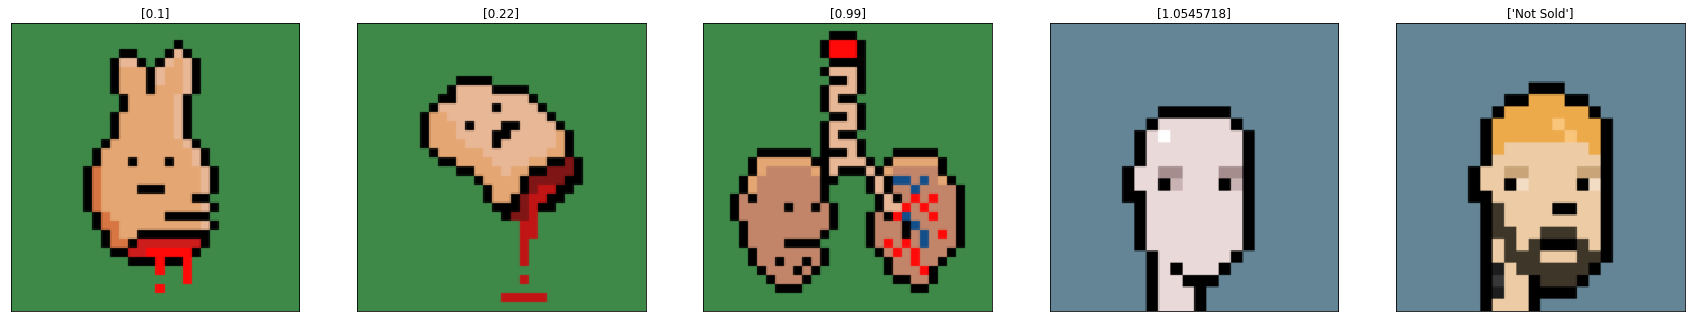

In [16]:
scores, indexes = cosknn.get_distances_and_indices([embds[sorted_args[324]]])

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

for i in range(5):
  fpath = image_files[int(indexes[0][i])]
  img = Image.open(fpath)
  axes[i].imshow(img)
  axes[i].set_title(get_price_info(fpath))
  axes[i].set_xticks([])
  axes[i].set_yticks([])
  
plt.show()

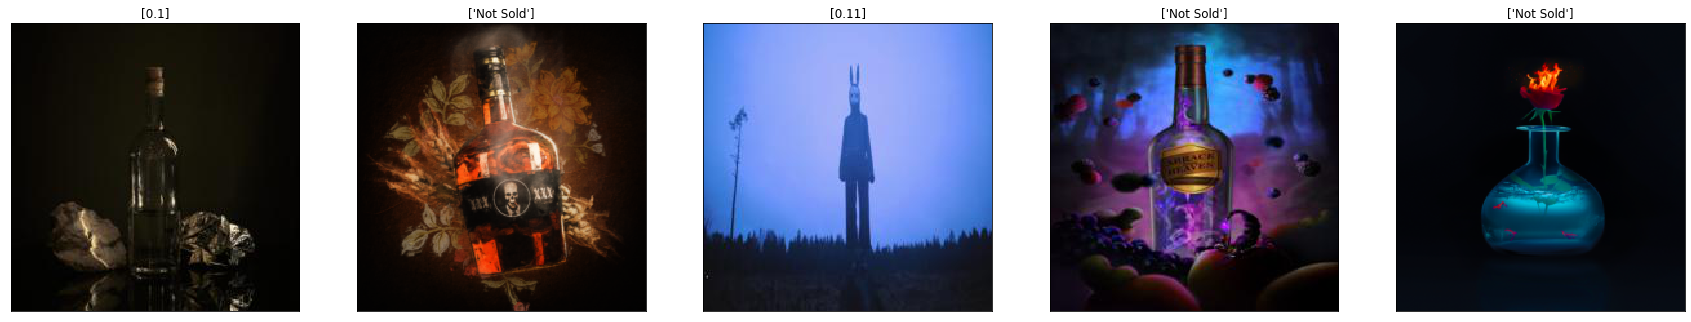

In [17]:
scores, indexes = cosknn.get_distances_and_indices([embds[sorted_args[554]]])

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

for i in range(5):
  fpath = image_files[int(indexes[0][i])]
  img = Image.open(fpath)
  axes[i].imshow(img)
  axes[i].set_title(get_price_info(fpath))
  axes[i].set_xticks([])
  axes[i].set_yticks([])
  
plt.show()

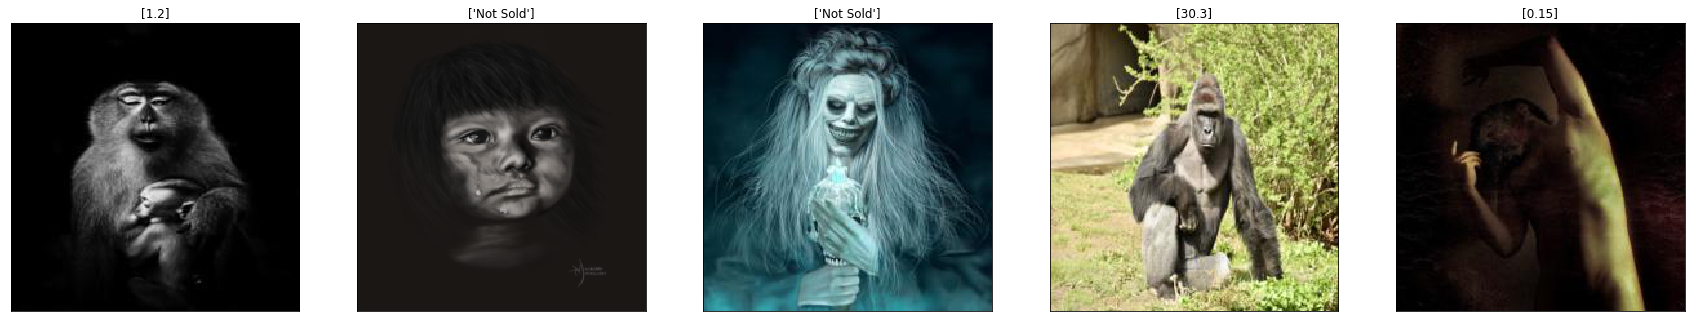

In [18]:
scores, indexes = cosknn.get_distances_and_indices([embds[sorted_args[6436]]])

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

for i in range(5):
  fpath = image_files[int(indexes[0][i])]
  img = Image.open(fpath)
  axes[i].imshow(img)
  axes[i].set_title(get_price_info(fpath))
  axes[i].set_xticks([])
  axes[i].set_yticks([])
  
plt.show()